In [1]:
import os
os.chdir("..")


In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

In [3]:
feature_dir = "data/processed/features"
train = pd.read_feather("chall1_all_feat_train_final.csv")
val = pd.read_feather("chall1_all_feat_val_final.csv")


In [4]:
# meanshift_train = pd.read_feather(
#     "data/processed/features/chall1_train_color_meanshift.feather")
# meanshift_val = pd.read_feather(
#     "data/processed/features/chall1_val_color_meanshift.feather")


In [5]:
# lbp_glcm = train.columns[:119]

In [6]:
# train = meanshift_train
# val = meanshift_val

In [7]:
# color_feats = train.columns[-96:].values

In [8]:
# train = train.merge(meanshift_train, on="image")
# val = val.merge(meanshift_val, on="image")


In [9]:
X_train = train.drop(columns='image')
X_train = X_train


train_cols = X_train.columns
y_train = train['image'].apply(lambda x: 0 if "nev" in x else 1)

X_test = val.drop(columns='image')
X_test = X_test
y_test = val['image'].apply(lambda x: 0 if "nev" in x else 1)


X_train[np.isnan(X_train)] = 0
X_train[np.isinf(X_train)] = 0
X_test[np.isnan(X_test)] = 0
X_test[np.isinf(X_test)] = 0


In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
svc = SVC(kernel='rbf', probability=True, class_weight='balanced', C=1.0)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
print('\nAccuracy: ', accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7725
           1       0.84      0.84      0.84      7470

    accuracy                           0.84     15195
   macro avg       0.84      0.84      0.84     15195
weighted avg       0.84      0.84      0.84     15195

Confusion Matrix
 [[6528 1197]
 [1175 6295]]

Accuracy:  0.8438960184271141


In [21]:
from xgboost import XGBClassifier

xgb_cl = XGBClassifier()

xgb_cl.fit(X_train, y_train)
y_pred = xgb_cl.predict(X_test)

print(classification_report(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
print('\nAccuracy: ', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1931
           1       0.78      0.80      0.79      1865

    accuracy                           0.79      3796
   macro avg       0.79      0.79      0.79      3796
weighted avg       0.79      0.79      0.79      3796

Confusion Matrix
 [[1503  428]
 [ 369 1496]]

Accuracy:  0.7900421496311907


# Verify replication

In [22]:
from sklearn.model_selection import train_test_split
X = meanshift_train.drop(columns=["image"])

# train_cols = X_train.columns
y = meanshift_train['image'].apply(lambda x: 0 if "nevus" in x else 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

X_train[np.isnan(X_train)] = 0
X_train[np.isinf(X_train)] = 0
X_test[np.isnan(X_test)] = 0
X_test[np.isinf(X_test)] = 0


In [23]:
classifier = SVC(max_iter=10000, kernel='rbf', probability=True)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, y_pred)}')


              precision    recall  f1-score   support

           0       0.64      0.82      0.72      2564
           1       0.74      0.52      0.61      2451

    accuracy                           0.68      5015
   macro avg       0.69      0.67      0.67      5015
weighted avg       0.69      0.68      0.67      5015

Accuracy: 0.676370887337986

Confusion Matrix: 
[[2112  452]
 [1171 1280]]


In [12]:
X_train.shape

(15195, 358)

# Feature Selection sklearn k-best


In [13]:
# ANOVA feature selection for numeric input and 
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import make_classification
# generate dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=2)
# define feature selection
fs = SelectKBest(score_func=f_classif, k=200)
# apply feature selection
X_train_selected = fs.fit_transform(X_train, y_train)
print(X_train_selected.shape)

(15195, 200)


In [14]:
svc = SVC(kernel='rbf', probability=True, class_weight='balanced', C=1.0)
svc.fit(X_train_selected, y_train)

y_pred = svc.predict(fs.transform(X_test))

print(classification_report(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
print('\nAccuracy: ', accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1931
           1       0.81      0.82      0.82      1865

    accuracy                           0.82      3796
   macro avg       0.82      0.82      0.82      3796
weighted avg       0.82      0.82      0.82      3796

Confusion Matrix
 [[1565  366]
 [ 330 1535]]

Accuracy:  0.8166491043203372


In [15]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate




clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)

# cols = data.columns[:-1]
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
feat_type="meanshift"
mask_type="default"
print(classification_report(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
print(f'\nAccuracy {feat_type}-{mask_type}', accuracy_score(y_test, y_pred))
print(f'\nF1-score avg {feat_type}-{mask_type}',
      f1_score(y_test, y_pred, average='weighted'))

enc = OneHotEncoder()
y_test_oh = enc.fit_transform(np.array(y_test).reshape(-1,1)).toarray()


output = cross_validate(clf, X_train, y_train, cv=10,
                        scoring='f1_micro', return_estimator=True)
feature_importances = []
for idx, estimator in enumerate(output['estimator']):
    feature_importances.append(pd.DataFrame(estimator.feature_importances_,
                                            index=train_cols,
                                            columns=['importance']).sort_values('importance', ascending=False))


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1931
           1       0.81      0.83      0.82      1865

    accuracy                           0.82      3796
   macro avg       0.82      0.82      0.82      3796
weighted avg       0.82      0.82      0.82      3796

Confusion Matrix
 [[1562  369]
 [ 309 1556]]

Accuracy meanshift-default 0.821390937829294

F1-score avg meanshift-default 0.8213954000872072


In [16]:
fi_res = pd.concat(feature_importances, axis=1).mean(
    axis=1).sort_values(ascending=False)
fi_res



hsv_s_mean     0.026316
lbp89          0.019297
hsv_h_std      0.015129
bgr_r_mean     0.014871
YCrCb_r_unq    0.014732
                 ...   
energy_5       0.001030
ASM_5          0.000998
energy_7       0.000963
hu_4           0.000823
hu_6           0.000788
Length: 358, dtype: float64

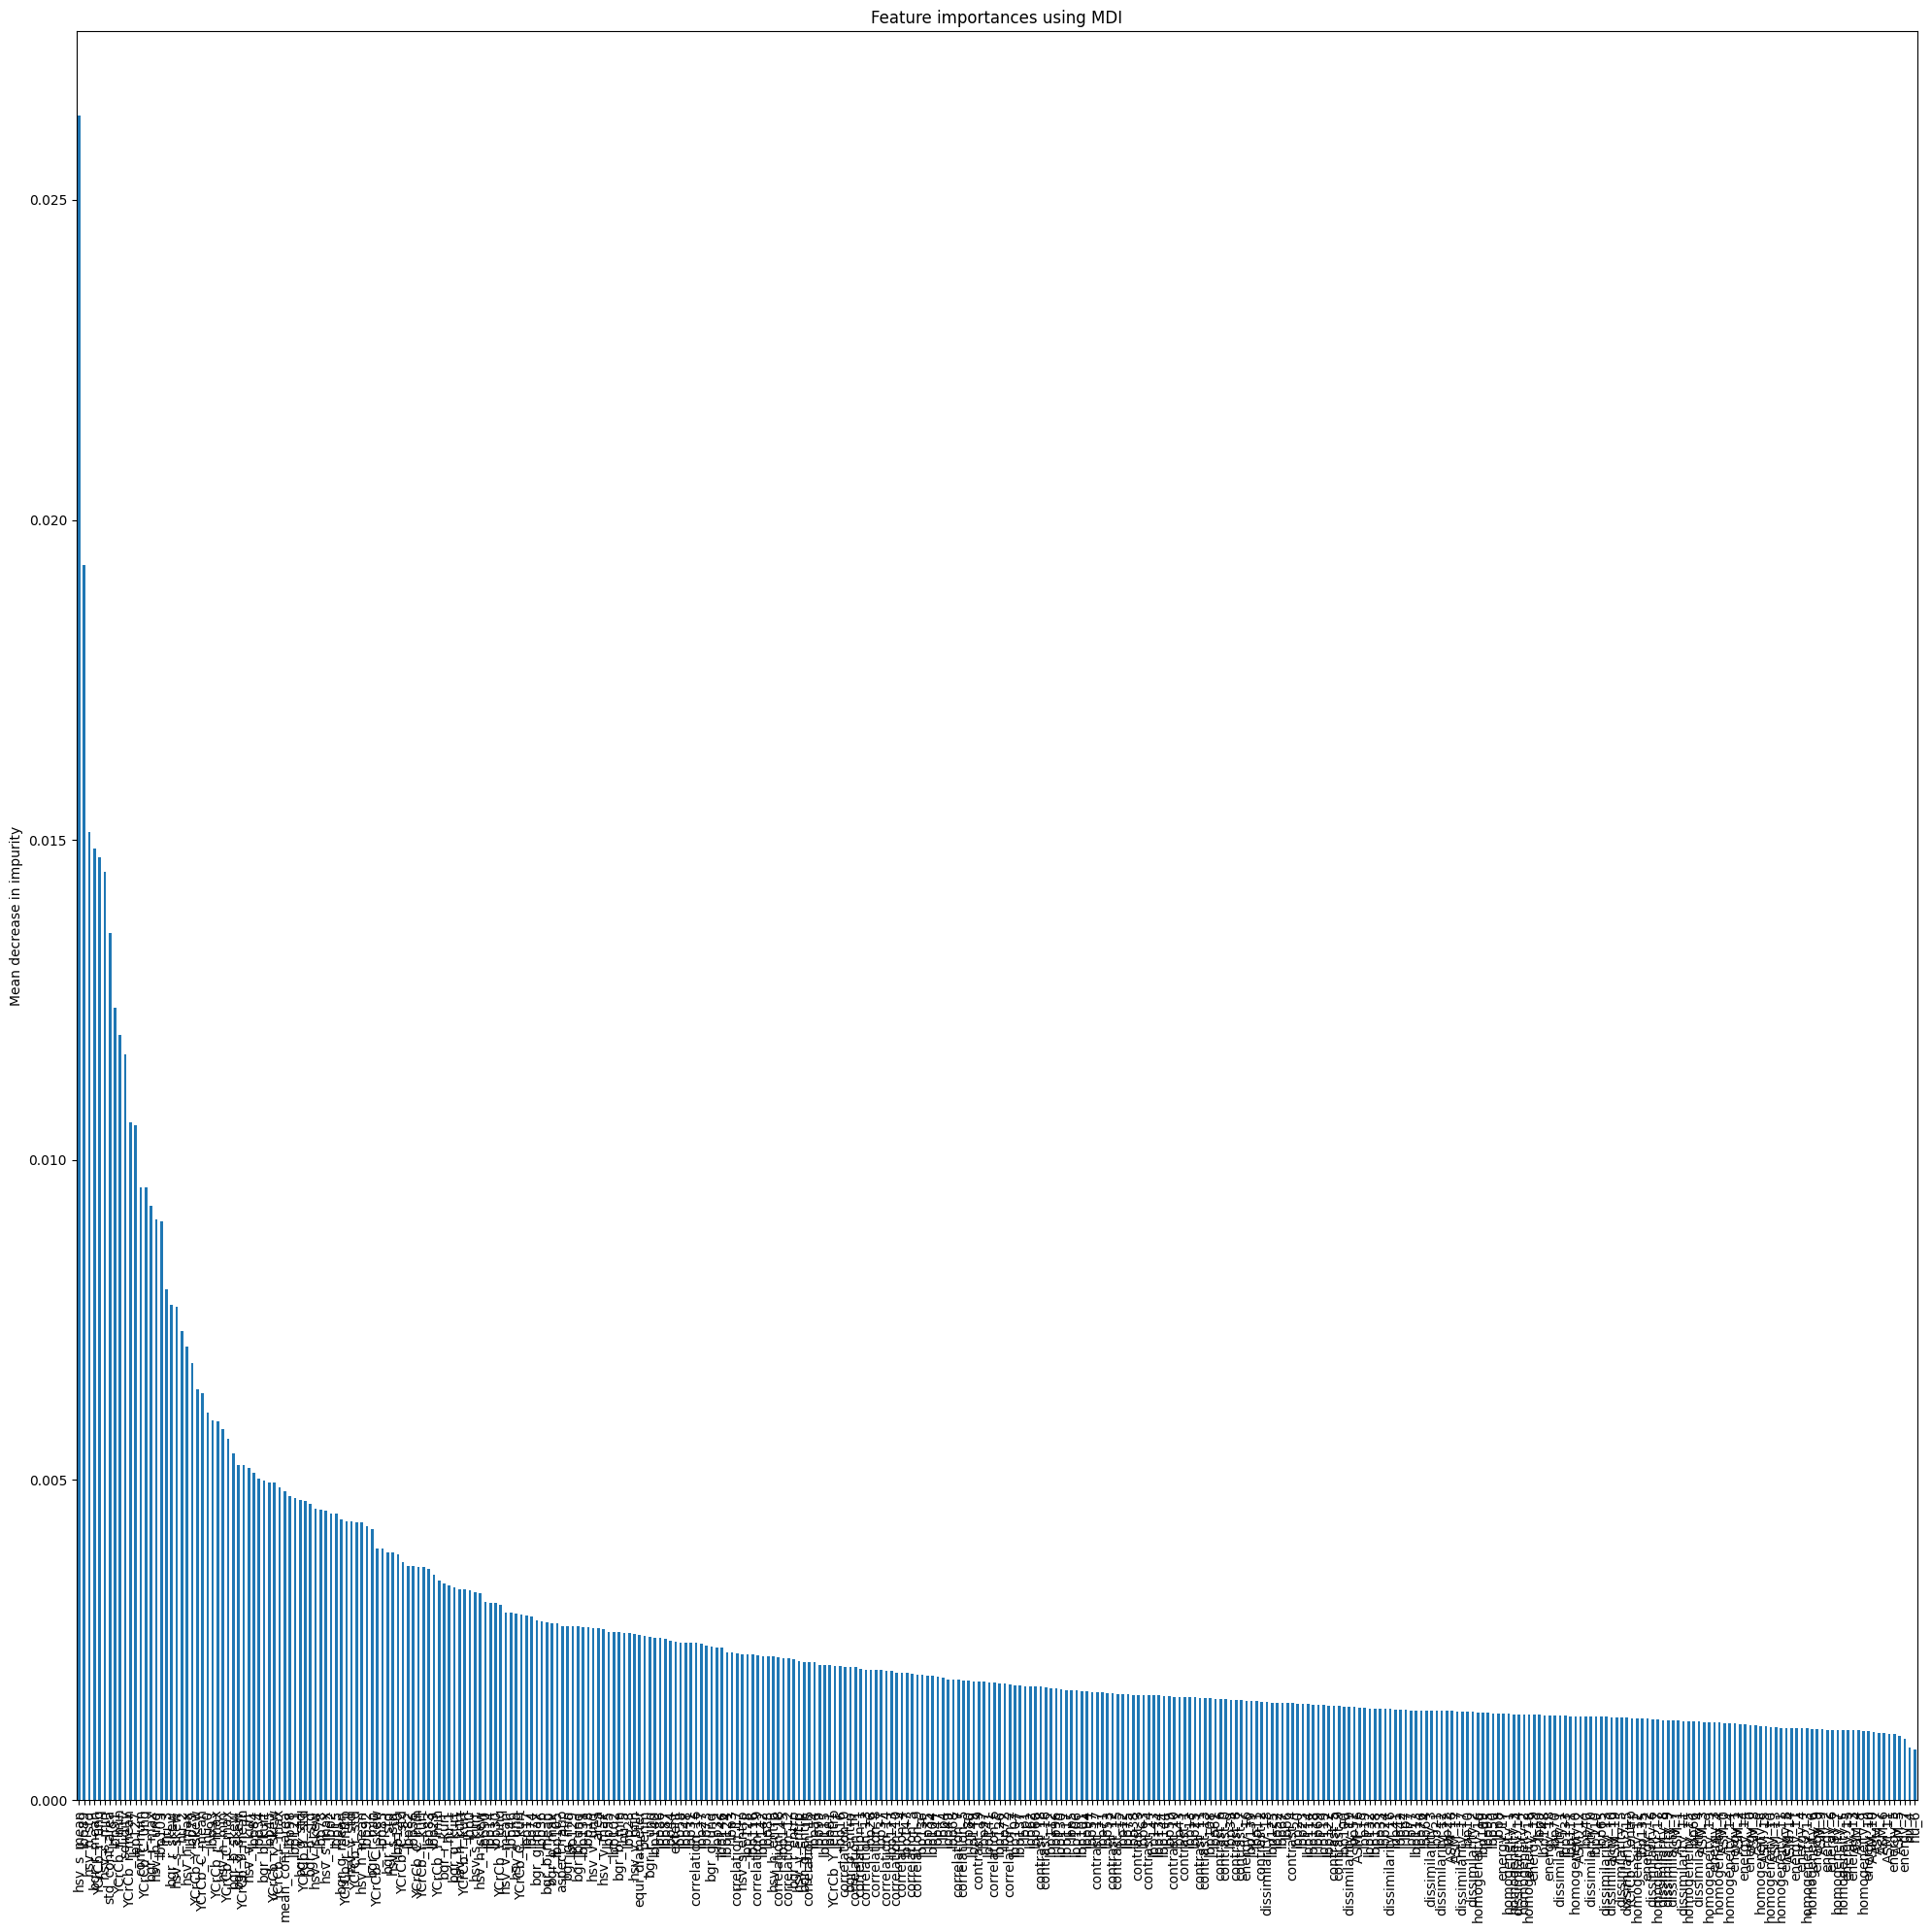

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
fi_res.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [21]:
from collections import Counter

In [24]:
['cont_num',
                    'mean_cont_area',
                    'std_cont_area',
                    'area',
                    'perim',
                    'aspect_ratio',
                    'extent',
                    'solidity',
                    'equi_diameter'
]

['cont_num',
 'mean_cont_area',
 'std_cont_area',
 'area',
 'perim',
 'aspect_ratio',
 'extent',
 'solidity',
 'equi_diameter']

In [27]:
import seaborn as sns

In [32]:
train.columns.unique().values

array(['bgr_b_mean', 'bgr_b_std', 'bgr_b_skew', 'bgr_b_kurt', 'bgr_b_max',
       'bgr_b_min', 'bgr_b_entrp', 'bgr_b_unq', 'bgr_g_mean', 'bgr_g_std',
       'bgr_g_skew', 'bgr_g_kurt', 'bgr_g_max', 'bgr_g_min',
       'bgr_g_entrp', 'bgr_g_unq', 'bgr_r_mean', 'bgr_r_std',
       'bgr_r_skew', 'bgr_r_kurt', 'bgr_r_max', 'bgr_r_min',
       'bgr_r_entrp', 'bgr_r_unq', 'hsv_h_mean', 'hsv_h_std',
       'hsv_h_skew', 'hsv_h_kurt', 'hsv_h_max', 'hsv_h_min',
       'hsv_h_entrp', 'hsv_h_unq', 'hsv_s_mean', 'hsv_s_std',
       'hsv_s_skew', 'hsv_s_kurt', 'hsv_s_max', 'hsv_s_min',
       'hsv_s_entrp', 'hsv_s_unq', 'hsv_v_mean', 'hsv_v_std',
       'hsv_v_skew', 'hsv_v_kurt', 'hsv_v_max', 'hsv_v_min',
       'hsv_v_entrp', 'hsv_v_unq', 'YCrCb_Y_mean', 'YCrCb_Y_std',
       'YCrCb_Y_skew', 'YCrCb_Y_kurt', 'YCrCb_Y_max', 'YCrCb_Y_min',
       'YCrCb_Y_entrp', 'YCrCb_Y_unq', 'YCrCb_C_mean', 'YCrCb_C_std',
       'YCrCb_C_skew', 'YCrCb_C_kurt', 'YCrCb_C_max', 'YCrCb_C_min',
       'YCrCb_C_entrp',

Text(0, 0.5, 'Number of features')

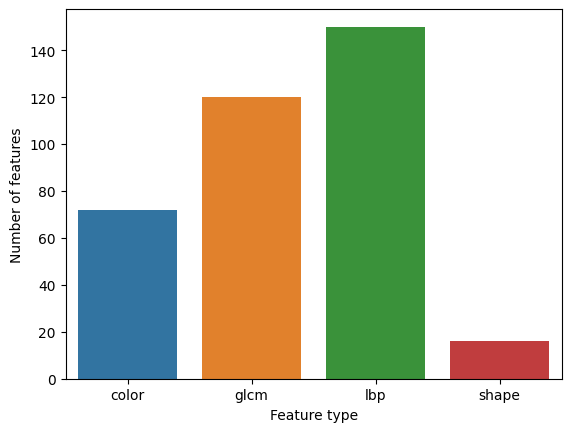

In [41]:
def check_subst_list(list_str, check_str):
    for l in list_str:
        if l in check_str:
            return True
    return False

feature_classes = {'color':[x for x in train.columns if check_subst_list(['bgr', 'hsv', 'YCrCb'],x)],
                   'glcm':[x for x in train.columns if check_subst_list(['contrast', 'dissimilarity',
                                                                                   'homogeneity', 'energy',
                                                                                   'correlation', 'ASM'], x)], 
                   'lbp': [x for x in train.columns if 'lbp' in x], 
                   'shape':[x for x in train.columns if check_subst_list(['cont_num',
 'mean_cont_area',
 'std_cont_area',
 'area',
 'perim',
 'aspect_ratio',
 'extent',
 'solidity',
 'equi_diameter','hu','cont_num'], x)]                  }

feature_importances_groupped = {k:0 for k in feature_classes.keys()}
feature_classes_inverted = {v:k for k,vv in feature_classes.items() for v in vv}

for fet, count in Counter(fi_res.index[:int(len(fi_res))]).items():
    feature_importances_groupped[feature_classes_inverted[fet]] += count
# normalize
feature_importances_groupped = {k:v for k,v in feature_importances_groupped.items()}
sns.barplot(x=list(feature_importances_groupped.keys()), y=list(feature_importances_groupped.values()))
plt.xlabel('Feature type')
plt.ylabel('Number of features')